# Deep Q learning

In [1]:
# maybe useful:
# https://towardsdatascience.com/reinforcement-learning-with-tensorflow-agents-tutorial-4ac7fa858728

In [2]:
import random
from time import sleep 
from engine import TetrisEngine

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [4]:
## use pip install --upgrade --force-reinstall  git+https://github.com/Bosmansc/tetris_openai.git
## not pip install  pip install keras-rl2, this is not compatible with the custom tetris environment

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.policy import GreedyQPolicy
from rl.memory import SequentialMemory

In [5]:
env = TetrisEngine()

In [6]:
def build_model_conv(actions):
    
    ## edit state based on code Seyedomid
    #resize(state)
    
    # Network defined by the Deepmind paper
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', 
                     kernel_constraint=max_norm(4), input_shape=(1, 16, 6)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    #model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    # end of convolutional layers, start of 'hidden' dense layers 
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer='he_uniform', kernel_constraint=max_norm(3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # Final dense layer
    model.add(Dense(actions, activation='linear'))
    
    return model

In [7]:
actions = 6
model = build_model_conv(actions)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 16, 32)         1760      
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 16, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 1, 16, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 16, 64)         18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 16, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 16, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 16, 64)         3

In [8]:
def build_agent(model, actions):
    # policy = GreedyQPolicy() ## hyperparm, GreedyQPolicy is used in paper: https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2008-118.pdf
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-2)
    return dqn

In [9]:
env.reset_environment()
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
history_training = dqn.fit(env, nb_steps=100, visualize=True)

Training for 100 steps ...
Interval 1 (0 steps performed)


/home/cbosmans/Documents/Projects/openai/openai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   98/10000 [..............................] - ETA: 1:55 - reward: 0.2163done, took 1.551 seconds


In [10]:
env.results().tail(2)

,nr_episode,heigt_diff_sum,new_block_sum,nr_lines_sum,score_sum,score_avg,count_steps
1,1.0,-14.0,8.0,0.0,5.6,0.243478,23
2,2.0,-2.0,1.0,0.0,-3.4,-0.200000,17


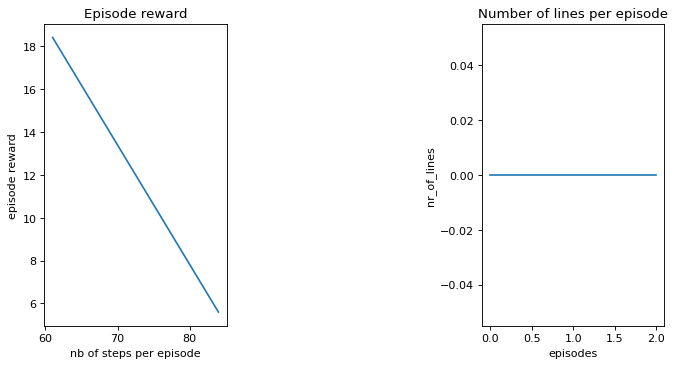

In [11]:
env.plot_results(history_training)

In [12]:
env.reset_environment()
history_test = dqn.test(env, nb_episodes=10, visualize=True
                  ,nb_max_episode_steps=300
                 )
print(np.mean(history_test.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 5.400, steps: 24
Episode 2: reward: 5.400, steps: 24
Episode 3: reward: 5.400, steps: 24
Episode 4: reward: 5.400, steps: 24
Episode 5: reward: 5.400, steps: 24
Episode 6: reward: 5.400, steps: 24
Episode 7: reward: 5.400, steps: 24
Episode 8: reward: 5.400, steps: 24
Episode 9: reward: 5.400, steps: 24
Episode 10: reward: 5.400, steps: 24
5.4


In [82]:
env.results().tail(2)

,nr_episode,heigt_diff_sum,new_block_sum,nr_lines_sum,score_sum,score_avg,count_steps
0,0.0,-20.0,1120.0,110260.0,40174.0,13.391333,3000


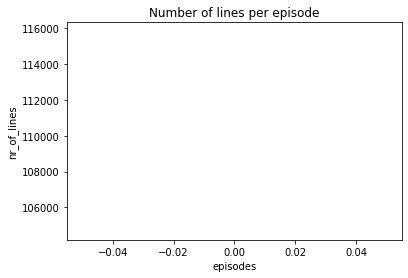

In [83]:
plot_lines(env.results())

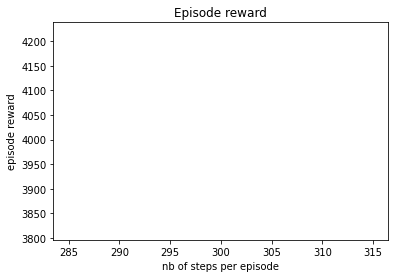

In [84]:
plot_history(history_test)

# save and load agent

In [85]:
## SAVE MODEL:
#dqn.save_weights('models/dqn_model_one_line.model', overwrite=False)

In [42]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.load_weights('models/dqn_model.model')

In [52]:
env.reset_environment()

scores = dqn.test(env, nb_episodes=5, visualize=True
                  ,nb_max_episode_steps=500
                 )
print(np.mean(scores.history['episode_reward']))

Testing for 5 episodes ...
Episode 1: reward: 7724.200, steps: 500
Episode 2: reward: 7724.200, steps: 500
Episode 3: reward: 7724.200, steps: 500
Episode 4: reward: 7724.200, steps: 500
Episode 5: reward: 7724.200, steps: 500
7724.2000000000535


# Graphs

In [53]:
import matplotlib.pyplot as plt


In [71]:
def plot_lines(df_results):
    x = df_results['nr_episode']
    y = df_results['nr_lines_sum']

    # plotting the points 
    plt.plot(x, y)

    # naming the x axis
    plt.xlabel('episodes')
    # naming the y axis
    plt.ylabel('nr_of_lines')

    # giving a title to my graph
    plt.title('Number of lines per episode')

    # function to show the plot
    plt.show()

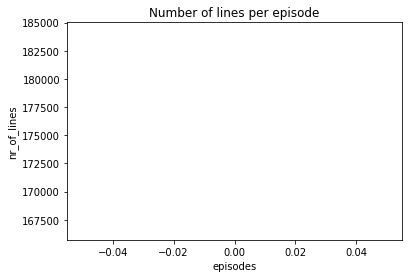

In [72]:
plot_lines(df_results)

In [80]:
def plot_history(history):
    x = history.history['nb_steps']
    y = history.history['episode_reward']

    # plotting the points 
    plt.plot(x, y)

    # naming the x axis
    plt.xlabel('nb of steps per episode')
    # naming the y axis
    plt.ylabel('episode reward')

    # giving a title to my graph
    plt.title('Episode reward')

    # function to show the plot
    plt.show()

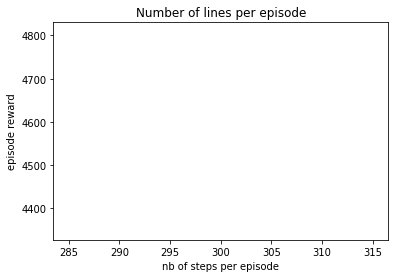

In [70]:
plot_history(history)

In [100]:
from matplotlib import pyplot

def plot_results(history):
    
    # input data
    df_results = env.results()
    history = history

    # init plot
    pyplot.figure(figsize=(10, 5), dpi=80)

    # PLOT EPISODE REWARD
    pyplot.subplot(131)
    x = history.history['nb_steps']
    y = history.history['episode_reward']

    # plotting the points 
    pyplot.plot(x, y)

    # naming the x axis
    pyplot.xlabel('nb of steps per episode')

    # naming the y axis
    pyplot.ylabel('episode reward')

    # title
    pyplot.title('Episode reward')

    # PLOT NR OF LINES
    pyplot.subplot(133)
    x = df_results['nr_episode']
    y = df_results['nr_lines_sum']

    # plotting the points 
    pyplot.plot(x, y)

    # naming the x axis
    pyplot.xlabel('episodes')
    # naming the y axis
    pyplot.ylabel('nr_of_lines')

    # title
    pyplot.title('Number of lines per episode')

    # show the plots
    pyplot.show()